# Supernovae Analysis with Markov Chain Monte Carlo

# Installing EMCEE

First we will install the most recently version of EMCEE library and the package Corner for corner plots. EMCEE is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler that will be used to estimate the posterior probability function. 

In [98]:
#Installing the EMCEE - Markov Chain Monte Carlo library
!pip install -U emcee

In [99]:
# Installing the Corner plot module
! python -m pip install corner

In [100]:
# Setting interative plots in the notebook from matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [101]:
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from corner import corner
import sys

In [102]:
df = pd.read_table("/kaggle/input/supernovae-pantheonsh0es-data/PantheonSH0ES.dat", sep="\s+")

In [103]:
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [119]:
df.shape

(1701, 47)

Text(0, 0.5, 'Distance Modulus')

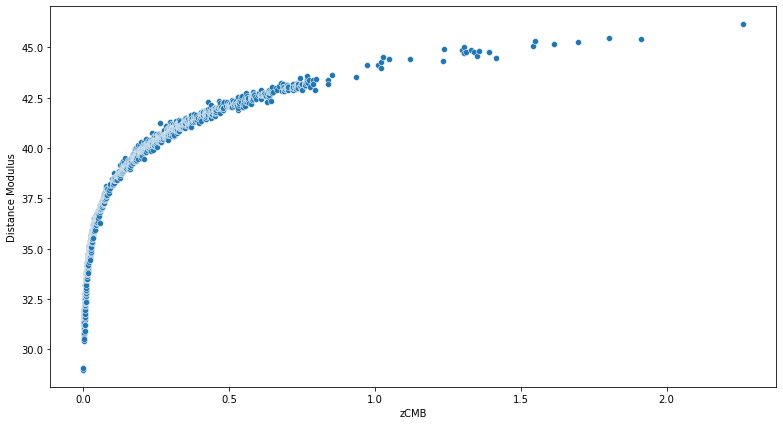

In [104]:
plt.figure(figsize=(13,7))
sns.scatterplot(x=df['zCMB'], y=df['MU_SH0ES'])
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

# Defining the Theoretical Model

In [105]:
# Importing the numerical integration package
from scipy.integrate import quad

In [106]:
# Defining the cosmological density parameters
Omega_r, Omega_m, H0, = 9*10**(-5), 0.31, 68/(3*10**19)
Omega_Lambda = 1-Omega_r-Omega_m

In [107]:
# The function we want to integrate
def f(z):
    return 1/(np.sqrt(Omega_r*(1+z)**4+Omega_m*(1+z)**3+Omega_Lambda))

In [108]:
# call quad to numerical integrate f using quadrature method
L=[]
for z in np.arange(0.01, 2.5, 0.01):
    res, err = quad(f, 0, z) # I discarted the integration error, but it can be stored
    L.append(res)
len(L)

250

In [109]:
cLight = 3*10**8 # Speed of light in vacuum
dH = cLight/H0 # Hubble length in Mpc

In [110]:
# Calculating the luminosity distance
z_list=[]
for z in np.arange(0.01,2.5,0.01):
    z_list.append(z)
dL=[]
for k in np.arange(0, 250):
    dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
print(len(z_list))
print(len(dL))

250
250


In [111]:
mu_model=[]
for k in range(0, 250):
    mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
len(mu_model)

250

Text(0, 0.5, 'Theoretical Distance Modulus')

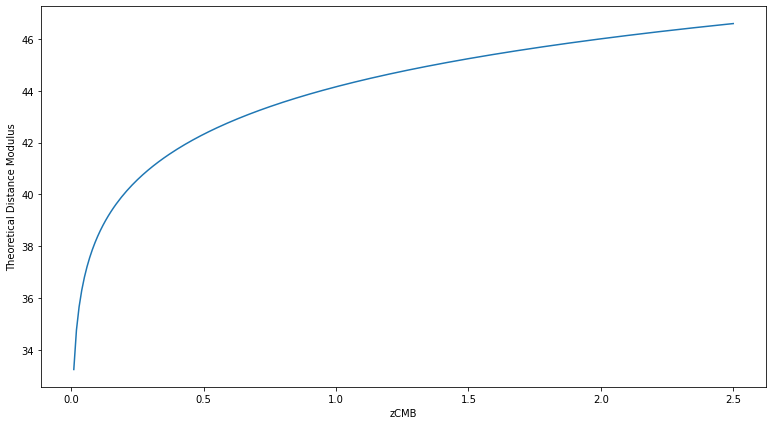

In [112]:
plt.figure(figsize=(13,7))
sns.lineplot(x=z_list, y=mu_model)
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

Text(0, 0.5, 'Distance Modulus')

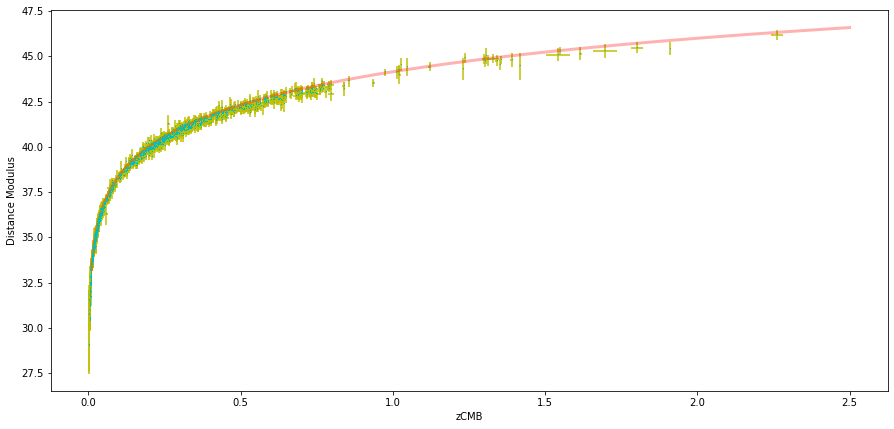

In [113]:
plt.figure(figsize=(15,7))
# Plot the error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)
# Plot the true line
x_theo=z_list
y_theo=mu_model
plt.plot(x_theo, y_theo, "r", alpha=0.3, lw=3)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

This is a comparison between theoretical and experimental distance modulos of 1701 supernovae. The error bars comes from the Pantheon+SH0ES data, the uncertainty on MU_SH0ES was determined from the diagonal of the covariance matrix and are only for plot purpose, cannot be used to fit cosmological parameters.

# Importing the Covariance Matrix

The format of the covariance (.cov) file is NxN lines where the matrix should be read in sequentially.  The first line gives the number of rows/columns in the matrix (N=1701).  The STATONLY matrix has only elements that correspond to the statistical distance uncertainties for individual SNe. This includes intrinsic scatter off-diagonal components when the light-curves represent the same SN observed by different surveys.

In [118]:
cov_aux = pd.read_table('/kaggle/input/pantheon-cov-matrix/Pantheon%2BSH0ES_STAT%2BSYS.cov')
cov_aux.head()

,1701
0,0.031771
1,0.005754
2,0.000310
3,0.001187
4,0.000083


In [120]:
cov_aux.shape

(2893401, 1)

In [156]:
cov_matrix = []
for i in range(1701):
    row = []
    for j in range(1701):
        row.append(cov_aux['1701'][j])
    cov_matrix.append(row)

In [157]:
len(cov_matrix)

1701

In [158]:
cov_matrix[0][0]

0.03177108

In [174]:
inv = np.linalg.inv(cov_matrix)

LinAlgError: Singular matrix

In [176]:
det = np.linalg.det(cov_matrix)
det

0.0

# Likelihood Distribution Calculation

In [115]:
def log_likelihood(mu_model, mu_data, cov):
   """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    cov_inv = np.linalg.inv(cov)
    cov_eigenvals = np.linalg.eig(cov)
    cov_len = len(cov)
    return -0.5 * ((mu_model - mu_data) @ cov_inv @ (mu_model - mu_data)) - .5 * (np.sum(np.log(cov_eigvals)) + cov_len * np.log(2*np.pi))

# Posterior Probability Function

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo method. According to Bayes Theorem, the posterior probability is given by:
$$  p(\theta|\vec{x}) \propto p(\theta)\mathcal{L}(\vec{x}|\theta)\,, $$

where $\theta$ is the cosmological parameters vector, $\vec{x}$ the input data and $\mathcal{L}(\vec{x}|\theta)$ is the likelihood function.

In [ ]:
# Defining the prior probability function

def log_prior(theta):
    Omega_m_est, Omega_r_est, H0_est = theta
    if 8.5*10**(-5) < Omega_m_est < 9.5*10**(-5) and 0.25 < Omega_r_est < 0.35 and 60/(3*10**19) < H0 < 75/(3*10**19):
        return 0.0
    return -np.inf

In [116]:
# Defining the full log-probability function

def log_probability(theta, mu_model, mu_data, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mu_model, mu_data, cov)

In [117]:
# Generating samples with emcee

pos = # Define the initial position
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

# Plotting the Parameters Estimatitive

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["Omega_m", "Omega_r", "H_0"]

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[Omega_m, Omega_r, H0]
);